<a href="https://colab.research.google.com/github/onurburakozdemir/FIZ437E/blob/main/HW3_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset2 = datasets.MNIST(root='./data', train=True, download=True)
test_dataset2 = datasets.MNIST(root='./data', train=False)

In [3]:
MNIST_train_dataset = []
MNIST_train_label = []
for i, (img, label) in enumerate(train_dataset2):
  img_arry = np.array(img)
  dtype = img_arry.dtype
  h, w = img_arry.shape
  img_arry = np.reshape(img_arry, [h, w, 1])
  img_arry = np.concatenate([img_arry, img_arry, img_arry], axis=2)
  MNIST_train_dataset.append(img_arry)
  MNIST_train_label.append(label)

MNIST_test_dataset = []
MNIST_test_label = []
for i, (img, label) in enumerate(test_dataset2):
  img_arry = np.array(img)
  dtype = img_arry.dtype
  h, w = img_arry.shape
  img_arry = np.reshape(img_arry, [h, w, 1])
  img_arry = np.concatenate([img_arry, img_arry, img_arry], axis=2)
  MNIST_test_dataset.append(img_arry)
  MNIST_test_label.append(label)

In [4]:
cMNIST_train_dataset = []
cMNIST_train_label = []
for i, (img, label) in enumerate(train_dataset2):
  img_arry = np.array(img)
  dtype = img_arry.dtype
  h, w = img_arry.shape
  img_arry = np.reshape(img_arry, [h, w, 1])
  if i < 15000:
    img_arry = np.concatenate([img_arry, 
                               np.zeros((h, w, 2), dtype=dtype)], axis=2)
  elif i < 30000:
    img_arry = np.concatenate([np.zeros((h, w, 2), dtype=dtype),
                               img_arry], axis=2)
  elif i < 45000:
    img_arry = np.concatenate([np.zeros((h, w, 1), dtype=dtype), img_arry, 
                               np.zeros((h, w, 1), dtype=dtype)], axis=2)
  else:
    img_arry = np.concatenate([img_arry, img_arry, 
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  cMNIST_train_dataset.append(img_arry)
  cMNIST_train_label.append(label)

cMNIST_test_dataset = []
cMNIST_test_label = []
for i, (img, label) in enumerate(test_dataset2):
  img_arry = np.array(img)
  dtype = img_arry.dtype
  h, w = img_arry.shape
  img_arry = np.reshape(img_arry, [h, w, 1])
  if i < 2500:
    img_arry = np.concatenate([img_arry,
                               np.zeros((h, w, 2), dtype=dtype)], axis=2)
  elif i < 5000:
    img_arry = np.concatenate([np.zeros((h, w, 2), dtype=dtype),
                               img_arry], axis=2)
  elif i < 7500:
    img_arry = np.concatenate([np.zeros((h, w, 1), dtype=dtype), img_arry, 
                               np.zeros((h, w, 1), dtype=dtype)], axis=2)
  else:
    img_arry = np.concatenate([img_arry, img_arry, 
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  cMNIST_test_dataset.append(img_arry)
  cMNIST_test_label.append(label)

In [5]:
c_train = [(img.astype(np.float32), 
             cMNIST_train_label[i]) 
             for i, img in enumerate(cMNIST_train_dataset)]

c_test = [(img.astype(np.float32), 
             cMNIST_test_label[i]) 
             for i, img in enumerate(cMNIST_test_dataset)]

bw_train = [(img.astype(np.float32), 
             MNIST_train_label[i]) 
             for i, img in enumerate(MNIST_train_dataset)]

bw_test = [(img.astype(np.float32), 
             MNIST_test_label[i]) 
             for i, img in enumerate(MNIST_test_dataset)]

In [6]:
c_train_loader = DataLoader(c_train, batch_size=32)
c_test_loader = DataLoader(c_test, batch_size=10000)
bw_train_loader = DataLoader(bw_train, batch_size=32)
bw_test_loader = DataLoader(bw_test, batch_size=10000)

In [21]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28*3, 64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64,10)
        # dropout prevents overfitting of data
        self.do = nn.Dropout(0.1)

    def forward(self,x):
        x = x.view(-1, 28 * 28 * 3)
        # hidden layer, with relu activation function
        h1 = nn.functional.relu(self.l1(x))
        # hidden layer, with relu activation function
        h2 =  nn.functional.relu(self.l2(h1))
        # dropout layer
        do = self.do(h2+h1)
        # output layer
        logits = self.l3(do)
        return logits # initialize the NN

Aşağıdaki hücrede model normal MNIST datasetinde eğitildi ve test edildi

In [ ]:
model = ResNet()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_accuracies = []
train_loss = []
test_accuracies = []
test_loss = []
n_epoch = 10
for i in range(n_epoch):
  accuracies=[]
  losses=[]
  for j, (images, labels) in enumerate(bw_train_loader):
    optimizer.zero_grad()
    outputs = model(images/255)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    accuracies.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
  train_accuracies.append(torch.tensor(accuracies).mean())
  train_loss.append(torch.tensor(losses).mean())
  print(f'Epoch {i+1}', end=',') 
  print(f'training loss: {torch.tensor(losses).mean():.2f}', end=',') 
  print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}',end='; ')

  with torch.no_grad():
    for j, (images, labels) in enumerate(bw_test_loader):
      outputs = model(images/255)
      loss = criterion(outputs, labels)

    test_accuracies.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
    test_loss.append(loss.item())
    print(f'test loss: {torch.tensor(losses).mean():.2f}', end=', ') 
    print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

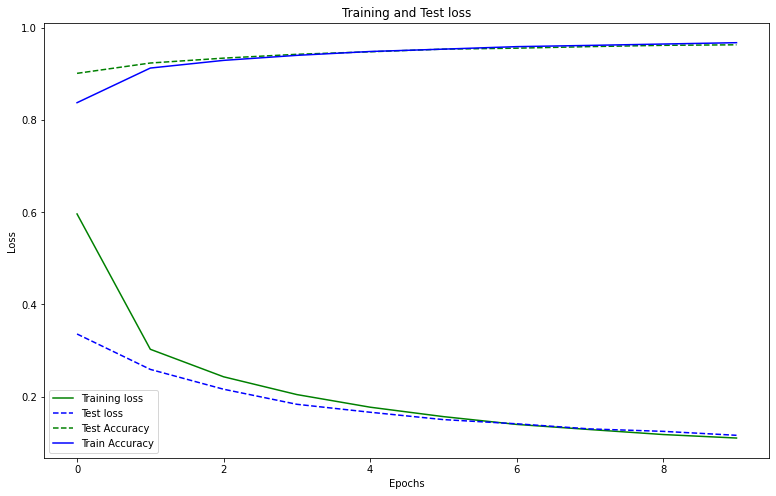

In [62]:
epochs = range(10)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, test_loss, '--b', label='Test loss')
plt.plot(epochs, test_accuracies, '--g', label='Test Accuracy')
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.rcParams["figure.figsize"] = (13 ,8)
plt.legend()
plt.show()

In [34]:
len(train_accuracies)

20

Aşağıdaki hücrede model Colored MNIST datasetinde eğitildi ve test edildi

In [64]:
model2 = ResNet()
optimizer = torch.optim.SGD(model2.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_accuracies2 = []
train_loss2 = []
test_accuracies2 = []
test_loss2 = []
n_epoch = 10
for i in range(n_epoch):
  accuracies=[]
  losses=[]
  for j, (images, labels) in enumerate(c_train_loader):
    optimizer.zero_grad()
    outputs = model2(images/255)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    accuracies.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
  train_accuracies2.append(torch.tensor(accuracies).mean())
  train_loss2.append(torch.tensor(losses).mean())
  print(f'Epoch {i+1}', end=',') 
  print(f'training loss: {torch.tensor(losses).mean():.2f}', end=',') 
  print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}',end='; ')

  with torch.no_grad():
    for j, (images, labels) in enumerate(c_test_loader):
      outputs = model2(images/255)
      loss = criterion(outputs, labels)

    test_accuracies2.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
    test_loss2.append(loss.item())
    print(f'test loss: {torch.tensor(losses).mean():.2f}', end=', ') 
    print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1,training loss: 1.00,training accuracy: 0.75; test loss: 1.00, test accuracy: 0.75
Epoch 2,training loss: 0.43,training accuracy: 0.88; test loss: 0.43, test accuracy: 0.88
Epoch 3,training loss: 0.35,training accuracy: 0.90; test loss: 0.35, test accuracy: 0.90
Epoch 4,training loss: 0.31,training accuracy: 0.91; test loss: 0.31, test accuracy: 0.91
Epoch 5,training loss: 0.27,training accuracy: 0.92; test loss: 0.27, test accuracy: 0.92
Epoch 6,training loss: 0.24,training accuracy: 0.93; test loss: 0.24, test accuracy: 0.93
Epoch 7,training loss: 0.22,training accuracy: 0.94; test loss: 0.22, test accuracy: 0.94
Epoch 8,training loss: 0.20,training accuracy: 0.94; test loss: 0.20, test accuracy: 0.94
Epoch 9,training loss: 0.18,training accuracy: 0.95; test loss: 0.18, test accuracy: 0.95
Epoch 10,training loss: 0.17,training accuracy: 0.95; test loss: 0.17, test accuracy: 0.95


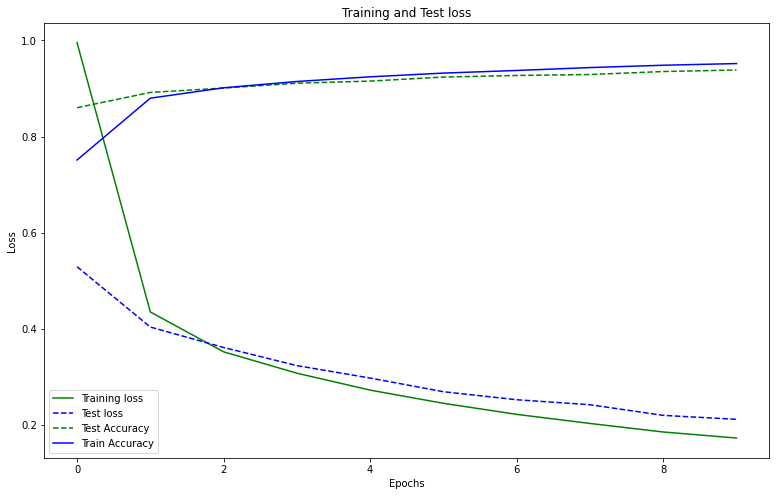

In [65]:
epochs = range(10)
plt.plot(epochs, train_loss2, 'g', label='Training loss')
plt.plot(epochs, test_loss2, '--b', label='Test loss')
plt.plot(epochs, test_accuracies2, '--g', label='Test Accuracy')
plt.plot(epochs, train_accuracies2, 'b', label='Train Accuracy')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.rcParams["figure.figsize"] = (13 ,8)
plt.legend()
plt.show()

Aşağıdaki hücrede model Colored MNIST datasetinde eğitildi ve normal MNIST'de test edildi

In [66]:
model3 = ResNet()
optimizer = torch.optim.SGD(model3.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_accuracies3 = []
train_loss3 = []
test_accuracies3 = []
test_loss3 = []
n_epoch = 10
for i in range(n_epoch):
  accuracies=[]
  losses=[]
  for j, (images, labels) in enumerate(c_train_loader):
    optimizer.zero_grad()
    outputs = model3(images/255)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    accuracies.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
  train_accuracies3.append(torch.tensor(accuracies).mean())
  train_loss3.append(torch.tensor(losses).mean())
  print(f'Epoch {i+1}', end=',') 
  print(f'training loss: {torch.tensor(losses).mean():.2f}', end=',') 
  print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}',end='; ')

  with torch.no_grad():
    for j, (images, labels) in enumerate(bw_test_loader):
      outputs = model3(images/255)
      loss = criterion(outputs, labels)

    test_accuracies3.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
    test_loss3.append(loss.item())
    print(f'test loss: {torch.tensor(losses).mean():.2f}', end=', ') 
    print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1,training loss: 1.01,training accuracy: 0.75; test loss: 1.01, test accuracy: 0.75
Epoch 2,training loss: 0.43,training accuracy: 0.88; test loss: 0.43, test accuracy: 0.88
Epoch 3,training loss: 0.35,training accuracy: 0.90; test loss: 0.35, test accuracy: 0.90
Epoch 4,training loss: 0.30,training accuracy: 0.91; test loss: 0.30, test accuracy: 0.91
Epoch 5,training loss: 0.27,training accuracy: 0.92; test loss: 0.27, test accuracy: 0.92
Epoch 6,training loss: 0.24,training accuracy: 0.93; test loss: 0.24, test accuracy: 0.93
Epoch 7,training loss: 0.22,training accuracy: 0.94; test loss: 0.22, test accuracy: 0.94
Epoch 8,training loss: 0.20,training accuracy: 0.94; test loss: 0.20, test accuracy: 0.94
Epoch 9,training loss: 0.18,training accuracy: 0.95; test loss: 0.18, test accuracy: 0.95
Epoch 10,training loss: 0.17,training accuracy: 0.95; test loss: 0.17, test accuracy: 0.95


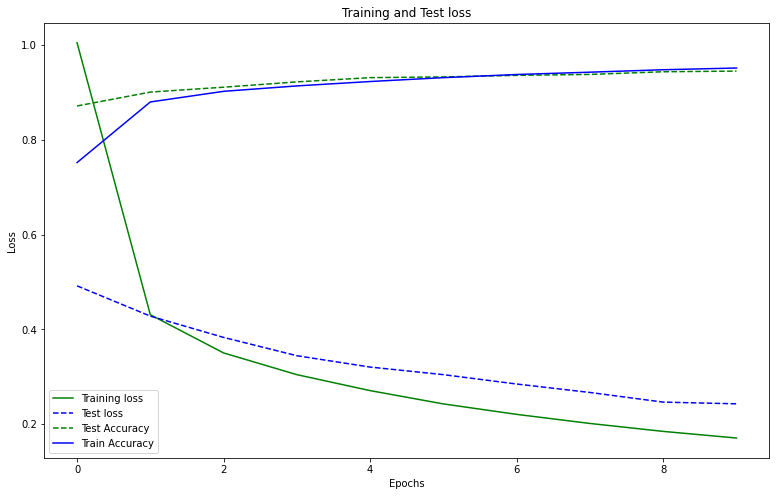

In [67]:
epochs = range(10)
plt.plot(epochs, train_loss3, 'g', label='Training loss')
plt.plot(epochs, test_loss3, '--b', label='Test loss')
plt.plot(epochs, test_accuracies3, '--g', label='Test Accuracy')
plt.plot(epochs, train_accuracies3, 'b', label='Train Accuracy')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.rcParams["figure.figsize"] = (13 ,8)
plt.legend()
plt.show()

Aşağıdaki hücrede model normal MNIST datasetinde eğitildi ve Colored MNIST'de test edildi

In [72]:
model4 = ResNet()
optimizer = torch.optim.SGD(model4.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_accuracies4 = []
train_loss4 = []
test_accuracies4 = []
test_loss4 = []
n_epoch = 10
for i in range(n_epoch):
  accuracies=[]
  losses=[]
  for j, (images, labels) in enumerate(bw_train_loader):
    optimizer.zero_grad()
    outputs = model4(images/255)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    accuracies.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
  train_accuracies4.append(torch.tensor(accuracies).mean())
  train_loss4.append(torch.tensor(losses).mean())
  print(f'Epoch {i+1}', end=',') 
  print(f'training loss: {torch.tensor(losses).mean():.2f}', end=',') 
  print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}',end='; ')

  with torch.no_grad():
    for j, (images, labels) in enumerate(c_test_loader):
      outputs = model4(images/255)
      loss = criterion(outputs, labels)

    test_accuracies4.append(labels.eq(outputs.detach().argmax(dim=1)).float().mean())
    test_loss4.append(loss.item())
    print(f'test loss: {torch.tensor(losses).mean():.2f}', end=', ') 
    print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1,training loss: 0.60,training accuracy: 0.84; test loss: 0.60, test accuracy: 0.84
Epoch 2,training loss: 0.30,training accuracy: 0.91; test loss: 0.30, test accuracy: 0.91
Epoch 3,training loss: 0.24,training accuracy: 0.93; test loss: 0.24, test accuracy: 0.93
Epoch 4,training loss: 0.20,training accuracy: 0.94; test loss: 0.20, test accuracy: 0.94
Epoch 5,training loss: 0.18,training accuracy: 0.95; test loss: 0.18, test accuracy: 0.95
Epoch 6,training loss: 0.16,training accuracy: 0.96; test loss: 0.16, test accuracy: 0.96
Epoch 7,training loss: 0.14,training accuracy: 0.96; test loss: 0.14, test accuracy: 0.96
Epoch 8,training loss: 0.13,training accuracy: 0.96; test loss: 0.13, test accuracy: 0.96
Epoch 9,training loss: 0.12,training accuracy: 0.97; test loss: 0.12, test accuracy: 0.97
Epoch 10,training loss: 0.11,training accuracy: 0.97; test loss: 0.11, test accuracy: 0.97


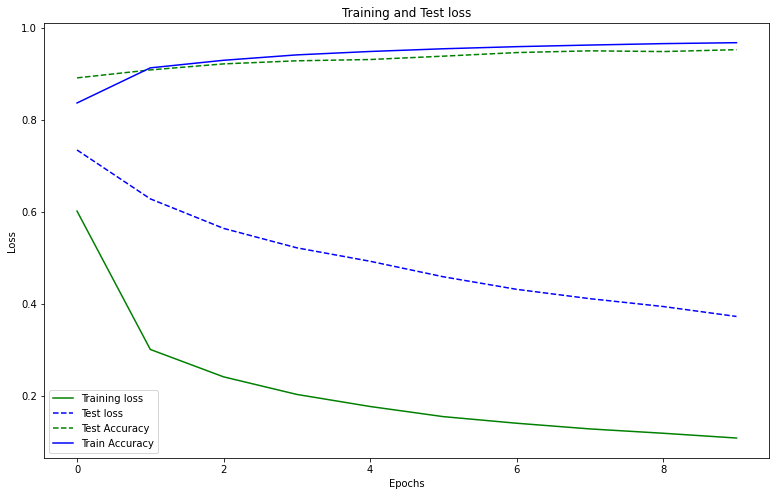

In [73]:
epochs = range(10)
plt.plot(epochs, train_loss4, 'g', label='Training loss')
plt.plot(epochs, test_loss4, '--b', label='Test loss')
plt.plot(epochs, test_accuracies4, '--g', label='Test Accuracy')
plt.plot(epochs, train_accuracies4, 'b', label='Train Accuracy')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.rcParams["figure.figsize"] = (13 ,8)
plt.legend()
plt.show()